In [1]:
import xgboost as xgb
import numpy as np
import pandas as pd
import time
import pickle
import os
from math import log
import matplotlib.pyplot as plt
from keras.optimizers import Adam

import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV,KFold, ParameterGrid,StratifiedKFold, cross_val_score

from sklearn import metrics 
from sklearn.metrics import confusion_matrix, precision_recall_curve, average_precision_score, brier_score_loss, f1_score, log_loss,auc,roc_curve,auc

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier

from sklearn.decomposition import PCA
#from sklearn.utils.fixes import signature

from datetime import datetime

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

Using TensorFlow backend.


In [2]:
os.chdir(r"C:\Users\aman.khatri91425\Desktop\HomeCredit\Bigdata\Corpus Classification")

In [3]:
df = pd.read_excel(os.getcwd()+r"\Data Files\New Categories\Corpus_Cereals_Grains.xlsx", encoding = 'unicode_escape')

In [4]:
df.head()

,spend_group,spend_cat_raw_l1,spend_cat_raw_l2,spend_cat_raw_l3,spend_cat_raw_l4,spend_cat_raw_l5,material_group_master_data,material_group_master_data_desc,material,material_desc,...,account_number,account_number_desc,cost_center,cost_center_desc,invoice_amount,invoice_amt_rep_curr_mth_rate,label_l2,label_l3,label_l4,label_l5
0,Raw,Cereals & Grains,C&G/ Wheat (not Durum),ZZ C&G/Whe/ Whole,ZZ C&G/Whe/ Whole,Not assigned,R10,Cereals & Grains,43896539,Wheat Soft Whole Grain Bumped 25kg Halal,...,N001/#,N001/Not assigned,0027/#,0027/Not assigned,790500.00,14837.86,C&G/ Wheat (not Durum),NaN,NaN,NaN
1,Raw,Cereals & Grains,C&G/ Wheat (not Durum),ZZ C&G/Whe/ Whole,Not assigned,Not assigned,R10,Cereals & Grains,43885489,Flour Wheat Whole 11%Protein 2.0%Ash,...,N001/#,N001/Not assigned,0051/#,0051/Not assigned,511036.67,72010.81,C&G/ Wheat (not Durum),NaN,NaN,NaN
2,Raw,Cereals & Grains,C&G/ Wheat (not Durum),ZZ C&G/Whe/ Whole,Not assigned,Not assigned,R10,Cereals & Grains,43932398,Flour Wheat Light Rstd 11%Prtn,...,N001/#,N001/Not assigned,0051/#,0051/Not assigned,-81175.66,-11505.57,C&G/ Wheat (not Durum),NaN,NaN,NaN
3,Raw,Cereals & Grains,C&G/ Wheat (not Durum),ZZ C&G/Whe/ Whole,Not assigned,Not assigned,R10,Cereals & Grains,43932398,Flour Wheat Light Rstd 11%Prtn,...,N001/#,N001/Not assigned,0051/#,0051/Not assigned,780260.64,109560.78,C&G/ Wheat (not Durum),NaN,NaN,NaN
4,Raw,Cereals & Grains,C&G/ Wheat (not Durum),ZZ C&G/Whe/ Whole,Not assigned,Not assigned,R10,Cereals & Grains,104169904,FARINA W 260 BellaNapoli_TRIAL,...,N001/#,N001/Not assigned,0046/#,0046/Not assigned,340.00,383.51,C&G/ Wheat (not Durum),NaN,NaN,NaN


In [5]:
df.label_l2= np.where((df.label_l2 == 'C&G/ Amaranth') | (df.label_l2 == 'C&G/ Triticale') | (df.label_l2 == 'C&G/ Wild Rice')
         | (df.label_l2 == 'C&G/ Spelt') | (df.label_l2 == 'C&G/ Mixed Grains') | (df.label_l2 == 'C&G/ Buckwheat')
         , "OTHERS",df.label_l2)

In [6]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(df["label_l2"])
df["label_l2_enc"]=le.transform(df["label_l2"])

df["CONCATED_COLUMN"] = df["material_descr_from_po"]+" "+df["vendor_desc"]+" "+df["account_number_desc"]+" "+df["cost_center_desc"]

# df["label_l2_enc"]=pd.get_dummies(df['label_l2']).values

In [7]:
x_column = ["material_descr_from_po","vendor_desc","account_number_desc","cost_center_desc","CONCATED_COLUMN"]
y_column = ["label_l2_enc"]
seed = 10

In [8]:
df.label_l2.value_counts()

C&G/ Wheat (not Durum)    1063
C&G/ Corn                  393
C&G/ Rice                  339
C&G/ Oat                   210
C&G/ Barley                160
OTHERS                      51
C&G/ Durum Wheat            51
C&G/ Quinoa                 42
C&G/ Millet                 26
C&G/ Rye                    26
C&G/ Sorghum                26
Name: label_l2, dtype: int64

In [9]:
X_train_1, X_test, y_train_1, y_test = train_test_split(df[x_column], df[y_column], test_size=0.2, random_state=seed)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_1, y_train_1, test_size=0.2, random_state=seed)

In [10]:
X_train.reset_index(inplace = True)
X_test.reset_index(inplace = True)
X_valid.reset_index(inplace = True)


In [11]:
print("Train sample : %.0f \t 24 MRO Services : %.1f \t 24 Workshop Equipment&Supplies : %.1f \tIndustrial Gases : %.1f" % (X_train.shape[0],
                                 round((y_train=="24 MRO Services").sum()/y_train.count()*100,2),
                                 round((y_train=="24 Workshop Equipment&Supplies").sum()/y_train.count()*100,2),
                                 round((y_train=="24 Industrial Gases").sum()/y_train.count()*100,2))
     )

print("valid sample : %.0f \t 24 MRO Services : %.1f \t 24 Workshop Equipment&Supplies : %.1f \tIndustrial Gases : %.1f" % (X_valid.shape[0],
                                 round((y_valid=="24 MRO Services").sum()/y_valid.count()*100,2),
                                 round((y_valid=="24 Workshop Equipment&Supplies").sum()/y_valid.count()*100,2),
                                 round((y_valid=="24 Industrial Gases").sum()/y_valid.count()*100,2))
     )

print("test sample : %.0f \t 24 MRO Services : %.1f \t 24 Workshop Equipment&Supplies : %.1f \tIndustrial Gases : %.1f" % (X_test.shape[0],
                                 round((y_test=="24 MRO Services").sum()/y_test.count()*100,2),
                                 round((y_test=="24 Workshop Equipment&Supplies").sum()/y_test.count()*100,2),
                                 round((y_test=="24 Industrial Gases").sum()/y_test.count()*100,2))
     )

Train sample : 1527 	 24 MRO Services : 0.0 	 24 Workshop Equipment&Supplies : 0.0 	Industrial Gases : 0.0
valid sample : 382 	 24 MRO Services : 0.0 	 24 Workshop Equipment&Supplies : 0.0 	Industrial Gases : 0.0
test sample : 478 	 24 MRO Services : 0.0 	 24 Workshop Equipment&Supplies : 0.0 	Industrial Gases : 0.0


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [12]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

selected_col = "CONCATED_COLUMN"

sentences_train = X_train[selected_col].values
sentences_valid = X_valid[selected_col].values
sentences_test = X_test[selected_col].values

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(sentences_train)


maxlen = 26


X_train = X_train.merge(pd.DataFrame(pad_sequences(tokenizer.texts_to_sequences(sentences_train), padding='post', maxlen=maxlen)),left_index=True, right_index = True)
X_test = X_test.merge(pd.DataFrame(pad_sequences(tokenizer.texts_to_sequences(sentences_test), padding='post', maxlen=maxlen)),left_index=True, right_index = True)
X_valid = X_valid.merge(pd.DataFrame(pad_sequences(tokenizer.texts_to_sequences(sentences_valid), padding='post', maxlen=maxlen)),left_index=True, right_index = True)
# X_test = tokenizer.texts_to_sequences(sentences_test)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

# print(sentences_train[2])
# print(X_train[2])

In [13]:
# from sklearn.feature_extraction.text import CountVectorizer

# for selected_col in x_column:
#     sentences_train = X_train[selected_col].values
#     sentences_valid = X_valid[selected_col].values
#     sentences_test = X_test[selected_col].values

#     vectorizer = CountVectorizer()
#     vectorizer.fit(sentences_train)

#     X_train = X_train.merge(pd.DataFrame(vectorizer.transform(sentences_train).toarray()),left_index=True, right_index = True)
#     X_valid = X_valid.merge(pd.DataFrame(vectorizer.transform(sentences_valid).toarray()),left_index=True, right_index = True)
#     X_test  = X_test.merge(pd.DataFrame(vectorizer.transform(sentences_test).toarray()),left_index=True, right_index = True)

In [14]:
all_col = list(X_train.columns)

In [15]:
all_col.remove('index')
all_col.remove('material_descr_from_po')
all_col.remove('vendor_desc')
all_col.remove('account_number_desc')
all_col.remove('cost_center_desc')
all_col.remove('CONCATED_COLUMN')

In [16]:
from keras.utils import to_categorical

# LSTM Model 

In [17]:
from keras.models import Sequential
from keras import layers

embedding_dim = 20

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
# model.add(layers.Flatten())
# model.add(layers.Dense(10, activation='relu'))
# model.add(layers.Dense(3, activation='sigmoid'))
model.add(layers.SpatialDropout1D(0.2))
model.add(layers.LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(layers.Dense(11, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 26, 20)            41120     
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 26, 20)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               48400     
_________________________________________________________________
dense_1 (Dense)              (None, 11)                1111      
Total params: 90,631
Trainable params: 90,631
Non-trainable params: 0
_________________________________________________________________


In [23]:
history = model.fit(X_train[all_col], to_categorical(y_train),
                     epochs=100,
                     verbose=False,
                     validation_data=(X_valid[all_col], to_categorical(y_valid)),
                     batch_size=50)

In [24]:
loss, accuracy = model.evaluate(X_train[all_col], to_categorical(y_train), verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_valid[all_col], to_categorical(y_valid), verbose=False)
print("Valid Accuracy:  {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test[all_col], to_categorical(y_test), verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9666
Valid Accuracy:  0.8743
Testing Accuracy:  0.8640


In [25]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

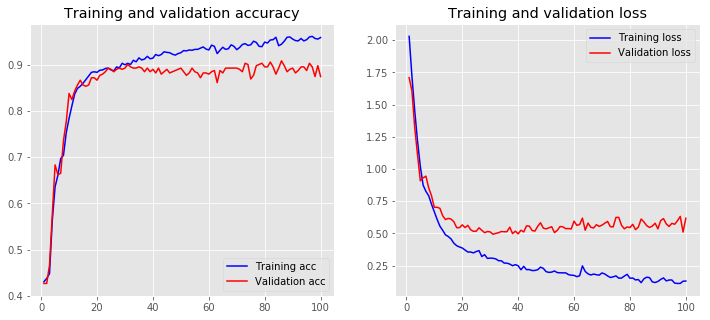

In [26]:
plot_history(history)

# Hyperparameter Tuning

In [27]:
# from keras.models import Sequential
# from keras import layers

# embedding_dim = 20

# model = Sequential()
# model.add(layers.Embedding(input_dim=vocab_size, 
#                            output_dim=embedding_dim, 
#                            input_length=maxlen))
# # model.add(layers.Flatten())
# # model.add(layers.Dense(10, activation='relu'))
# # model.add(layers.Dense(3, activation='sigmoid'))
# model.add(layers.SpatialDropout1D(0.2))
# model.add(layers.LSTM(100, dropout=0.2, recurrent_dropout=0.2))
# model.add(layers.Dense(3, activation='softmax'))

# model.compile(optimizer='adam',
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])
# model.summary()

In [19]:
def create_model(learning_rate=0.01, activation='relu', embedding_dim=20, n_lstm=100, dropout = 0.2, recurrent_dropout=0.2):
  
    # Create an Adam optimizer with the given learning rate
    opt = Adam(lr=learning_rate)
  
    # Create your binary classification model  
    

    model = Sequential()
    model.add(layers.Embedding(input_dim=vocab_size, 
                               output_dim=embedding_dim, 
                               input_length=maxlen))
#     model.add(layers.Flatten())
#     model.add(layers.Dense(n_dense, activation=activation))
#     model.add(layers.Dense(3, activation='sigmoid'))

    model.add(layers.SpatialDropout1D(dropout))
    model.add(layers.LSTM(n_lstm, dropout=dropout, recurrent_dropout=recurrent_dropout))
    model.add(layers.Dense(11, activation='softmax'))
    model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    
    return model

In [29]:
params = {'activation': ["relu", "tanh"],
          'batch_size': [25, 32, 40], 
          'epochs': [10,12,15],
          'learning_rate': [0.01, 0.001, 0.0005],
          'embedding_dim' : [10,15,20,25,30],
          'n_lstm' : [50,70,100,120],
          'dropout' : [0.1,0.15,0.2,0.25,0.3], 
          'recurrent_dropout' : [0.1,0.15,0.2,0.25,0.3]
         }

In [30]:
from keras.wrappers.scikit_learn import KerasRegressor
model = KerasRegressor(build_fn = create_model,
                       verbose = 1)

In [31]:
random_search = RandomizedSearchCV(model,
                                   param_distributions = params, random_state = 10, n_iter = 20,
                                   cv = KFold(3), error_score=0, return_train_score =True)



In [32]:
print("Randomized search..")
search_time_start = time.time()
random_search.fit(X_train[all_col], to_categorical(y_train))
print("Randomized search time:", time.time() - search_time_start)

Randomized search..
Epoch 1/10
1018/1018 [==============================] - 5s 5ms/step - loss: 2.0051 - accuracy: 0.4126
Epoch 2/10
1018/1018 [==============================] - 3s 3ms/step - loss: 1.7218 - accuracy: 0.4460
Epoch 3/10
1018/1018 [==============================] - 4s 4ms/step - loss: 1.5341 - accuracy: 0.4538
Epoch 4/10
1018/1018 [==============================] - 3s 3ms/step - loss: 1.2621 - accuracy: 0.5580
Epoch 5/10
1018/1018 [==============================] - 3s 3ms/step - loss: 1.0699 - accuracy: 0.6277
Epoch 6/10
1018/1018 [==============================] - 3s 3ms/step - loss: 0.9356 - accuracy: 0.6847
Epoch 7/10
1018/1018 [==============================] - 3s 3ms/step - loss: 0.8497 - accuracy: 0.7102
Epoch 8/10
1018/1018 [==============================] - 3s 3ms/step - loss: 0.7681 - accuracy: 0.7436
Epoch 9/10
1018/1018 [==============================] - 3s 3ms/step - loss: 0.7373 - accuracy: 0.7574
Epoch 10/10
1018/1018 [==============================] - 1s 94

1018/1018 [==============================] - 3s 3ms/step - loss: 0.7026 - accuracy: 0.7633
Epoch 10/10
1018/1018 [==============================] - 1s 754us/step
Epoch 1/10
1018/1018 [==============================] - 6s 6ms/step - loss: 2.1112 - accuracy: 0.3919
Epoch 2/10
1018/1018 [==============================] - 3s 3ms/step - loss: 1.7639 - accuracy: 0.4381
Epoch 3/10
1018/1018 [==============================] - 3s 3ms/step - loss: 1.6507 - accuracy: 0.4381
Epoch 4/10
1018/1018 [==============================] - 3s 3ms/step - loss: 1.3641 - accuracy: 0.4637
Epoch 5/10
1018/1018 [==============================] - 3s 3ms/step - loss: 1.2300 - accuracy: 0.5472
Epoch 6/10
1018/1018 [==============================] - 3s 3ms/step - loss: 1.0424 - accuracy: 0.6503
Epoch 7/10
1018/1018 [==============================] - 3s 3ms/step - loss: 0.9372 - accuracy: 0.6650
Epoch 8/10
1018/1018 [==============================] - 3s 3ms/step - loss: 0.8401 - accuracy: 0.7132
Epoch 9/10
1018/1018 [

1018/1018 [==============================] - 3s 3ms/step - loss: 1.1869 - accuracy: 0.5953
Epoch 8/12
1018/1018 [==============================] - 3s 3ms/step - loss: 1.1342 - accuracy: 0.6149
Epoch 9/12
1018/1018 [==============================] - 3s 3ms/step - loss: 1.0030 - accuracy: 0.6562
Epoch 10/12
1018/1018 [==============================] - 3s 3ms/step - loss: 0.8709 - accuracy: 0.7151
Epoch 11/12
1018/1018 [==============================] - 3s 3ms/step - loss: 0.7955 - accuracy: 0.7417
Epoch 12/12
1018/1018 [==============================] - 1s 995us/step
Epoch 1/12
1018/1018 [==============================] - 5s 5ms/step - loss: 2.2742 - accuracy: 0.4047
Epoch 2/12
1018/1018 [==============================] - 2s 2ms/step - loss: 1.7583 - accuracy: 0.4460
Epoch 3/12
1018/1018 [==============================] - 2s 2ms/step - loss: 1.7175 - accuracy: 0.4460
Epoch 4/12
1018/1018 [==============================] - 2s 2ms/step - loss: 1.7037 - accuracy: 0.4460
Epoch 5/12
1018/1018

1018/1018 [==============================] - 1s 1ms/step
Epoch 1/12
1018/1018 [==============================] - 5s 5ms/step - loss: 2.1853 - accuracy: 0.4126
Epoch 2/12
1018/1018 [==============================] - 2s 2ms/step - loss: 1.7488 - accuracy: 0.4460
Epoch 3/12
1018/1018 [==============================] - 2s 2ms/step - loss: 1.7221 - accuracy: 0.4460
Epoch 4/12
1018/1018 [==============================] - 2s 2ms/step - loss: 1.7137 - accuracy: 0.4460
Epoch 5/12
1018/1018 [==============================] - 2s 2ms/step - loss: 1.6204 - accuracy: 0.4470
Epoch 6/12
1018/1018 [==============================] - 2s 2ms/step - loss: 1.3595 - accuracy: 0.5029
Epoch 7/12
1018/1018 [==============================] - 5s 5ms/step - loss: 1.1952 - accuracy: 0.5580
Epoch 8/12
1018/1018 [==============================] - 3s 3ms/step - loss: 1.0859 - accuracy: 0.5855
Epoch 9/12
1018/1018 [==============================] - 3s 3ms/step - loss: 1.0654 - accuracy: 0.5953
Epoch 10/12
1018/1018 [==

1018/1018 [==============================] - 1s 1ms/step
Epoch 1/15
1018/1018 [==============================] - 7s 6ms/step - loss: 2.1049 - accuracy: 0.3802
Epoch 2/15
1018/1018 [==============================] - 3s 3ms/step - loss: 1.7511 - accuracy: 0.4283
Epoch 3/15
1018/1018 [==============================] - 3s 3ms/step - loss: 1.6487 - accuracy: 0.4293
Epoch 4/15
1018/1018 [==============================] - 3s 3ms/step - loss: 1.3987 - accuracy: 0.4764
Epoch 5/15
1018/1018 [==============================] - 3s 3ms/step - loss: 1.1880 - accuracy: 0.6248
Epoch 6/15
1018/1018 [==============================] - 3s 3ms/step - loss: 0.9726 - accuracy: 0.6690
Epoch 7/15
1018/1018 [==============================] - 3s 3ms/step - loss: 0.8896 - accuracy: 0.7063
Epoch 8/15
1018/1018 [==============================] - 3s 3ms/step - loss: 0.8134 - accuracy: 0.7269
Epoch 9/15
1018/1018 [==============================] - 3s 3ms/step - loss: 0.7328 - accuracy: 0.7682
Epoch 10/15
1018/1018 [==

1018/1018 [==============================] - 3s 3ms/step - loss: 1.3621 - accuracy: 0.5363
Epoch 6/12
1018/1018 [==============================] - 3s 3ms/step - loss: 1.1493 - accuracy: 0.6022
Epoch 7/12
1018/1018 [==============================] - 3s 3ms/step - loss: 1.0849 - accuracy: 0.6228
Epoch 8/12
1018/1018 [==============================] - 3s 3ms/step - loss: 1.0429 - accuracy: 0.6444
Epoch 9/12
1018/1018 [==============================] - 3s 3ms/step - loss: 0.9868 - accuracy: 0.6660
Epoch 10/12
1018/1018 [==============================] - 3s 3ms/step - loss: 0.9066 - accuracy: 0.6974
Epoch 11/12
1018/1018 [==============================] - 3s 3ms/step - loss: 0.8423 - accuracy: 0.7230
Epoch 12/12
1018/1018 [==============================] - 1s 1ms/step
Epoch 1/12
1018/1018 [==============================] - 3s 3ms/step - loss: 2.0318 - accuracy: 0.4037
Epoch 2/12
1018/1018 [==============================] - 1s 1ms/step - loss: 1.7663 - accuracy: 0.4381
Epoch 3/12
1018/1018 [

In [33]:
print("Best Score: ",
      random_search.best_score_,
      "and Best Params: ",
      random_search.best_params_)

Best Score:  -0.8314788846815031 and Best Params:  {'recurrent_dropout': 0.25, 'n_lstm': 100, 'learning_rate': 0.001, 'epochs': 10, 'embedding_dim': 25, 'dropout': 0.3, 'batch_size': 25, 'activation': 'tanh'}


## Fit Best Model

In [20]:
model = create_model(learning_rate=0.001, activation='tanh', embedding_dim=25, n_lstm=100, dropout = 0.3, recurrent_dropout=0.25)

In [31]:
history = model.fit(X_train[all_col], to_categorical(y_train),
                     epochs=37,
                     verbose=False,
                     validation_data=(X_valid[all_col], to_categorical(y_valid)),
                     batch_size=25)

In [32]:
loss, accuracy = model.evaluate(X_train[all_col], to_categorical(y_train), verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_valid[all_col], to_categorical(y_valid), verbose=False)
print("Valid Accuracy:  {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test[all_col], to_categorical(y_test), verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9993
Valid Accuracy:  0.9162
Testing Accuracy:  0.9163


In [33]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

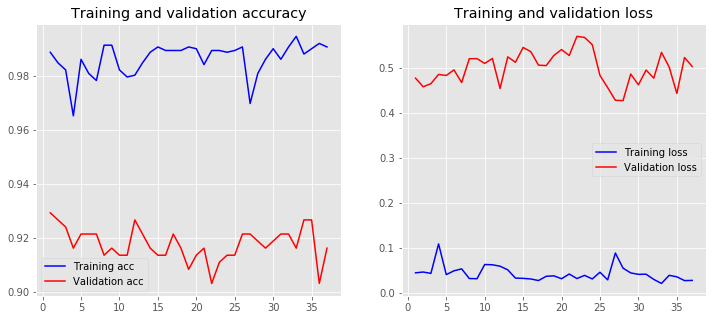

In [34]:
plot_history(history)

# Model Evaluation: Test Data

In [35]:
score, acc = model.evaluate(X_test[all_col], to_categorical(y_test),
                       batch_size=16, verbose=2)

print('Test accuracy:', acc)

Test accuracy: 0.9163179993629456


Confusion matrix, without normalization


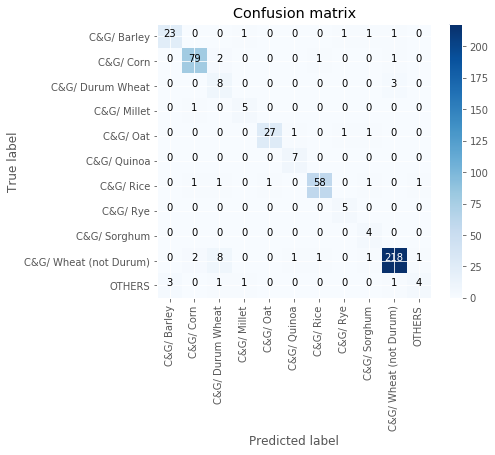

In [36]:
text_labels = le.classes_
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


y_pred = pd.DataFrame(model.predict_classes(X_test[all_col]));
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
fig = plt.figure()
fig.set_size_inches(7, 6, forward=True)
#fig.align_labels()

# fig.subplots_adjust(left=0.0, right=1.0, bottom=0.0, top=1.0)
plot_confusion_matrix(cnf_matrix, classes=np.asarray(text_labels), normalize=False,
                      title='Confusion matrix')

fig.savefig("txt_classification_NN_BOW" + ".png", pad_inches=5.0)


In [37]:
from sklearn.metrics import cohen_kappa_score
cohen_score = cohen_kappa_score(y_test, y_pred)
cohen_score

0.8833100400969162

In [38]:
from sklearn.metrics import precision_recall_fscore_support as score

precision, recall, fscore, support = score(y_test, y_pred)


score_dic= {'Labels':text_labels,
           'precision':precision,
            'recall':recall,
            'fscore':fscore,
            'support':support
           }

pd.DataFrame(score_dic)


,Labels,precision,recall,fscore,support
0,C&G/ Barley,0.884615,0.851852,0.867925,27
1,C&G/ Corn,0.951807,0.951807,0.951807,83
2,C&G/ Durum Wheat,0.400000,0.727273,0.516129,11
3,C&G/ Millet,0.714286,0.833333,0.769231,6
4,C&G/ Oat,0.964286,0.900000,0.931034,30
5,C&G/ Quinoa,0.777778,1.000000,0.875000,7
6,C&G/ Rice,0.966667,0.920635,0.943089,63
7,C&G/ Rye,0.714286,1.000000,0.833333,5
8,C&G/ Sorghum,0.500000,1.000000,0.666667,4
9,C&G/ Wheat (not Durum),0.973214,0.939655,0.956140,232


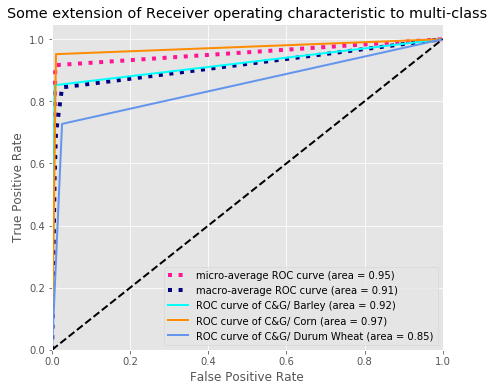

In [39]:
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle

num_labels = 3
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_labels):
    fpr[i], tpr[i], _ = roc_curve((y_test==i), (y_pred == i))
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(to_categorical(y_test).ravel(), to_categorical(y_pred).ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_labels)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_labels):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= num_labels

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
fig = plt.figure()
fig.set_size_inches(7, 6, forward=True)
# plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(num_labels), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of {0} (area = {1:0.2f})'
             ''.format(text_labels[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [40]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(num_labels):
    precision[i], recall[i], _ = precision_recall_curve((y_test==i), (y_pred == i))
    average_precision[i] = average_precision_score((y_test==i), (y_pred == i))

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(to_categorical(y_test).ravel(), to_categorical(y_pred).ravel())
average_precision["micro"] = average_precision_score(to_categorical(y_test), to_categorical(y_pred),
                                                     average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'
      .format(average_precision["micro"]))

Average precision score, micro-averaged over all classes: 0.85


Text(0.5, 1.0, 'Average precision score, micro-averaged over all classes: AP=0.85')

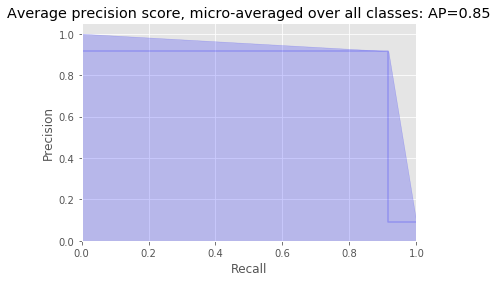

In [41]:
plt.figure()
plt.step(recall['micro'], precision['micro'], color='b', alpha=0.2,
         where='post')
plt.fill_between(recall["micro"], precision["micro"], alpha=0.2, color='b')#,
                 #**step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(
    'Average precision score, micro-averaged over all classes: AP={0:0.2f}'
    .format(average_precision["micro"]))

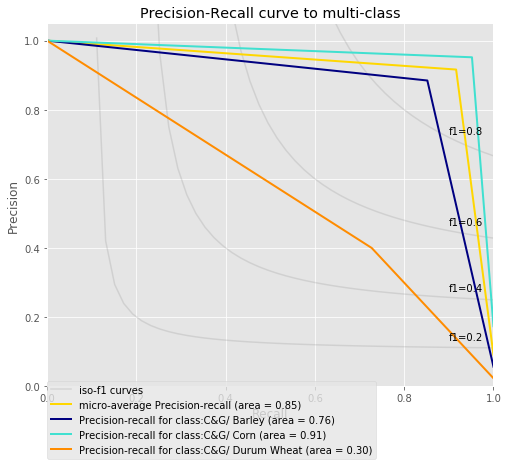

In [42]:
from itertools import cycle
# setup plot details
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])

plt.figure(figsize=(8, 8))
f_scores = np.linspace(0.2, 0.8, num=4)
lines = []
labels = []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

lines.append(l)
labels.append('iso-f1 curves')
l, = plt.plot(recall["micro"], precision["micro"], color='gold', lw=2)
lines.append(l)
labels.append('micro-average Precision-recall (area = {0:0.2f})'
              ''.format(average_precision["micro"]))

for i, color in zip(range(num_labels), colors):
    l, = plt.plot(recall[i], precision[i], color=color, lw=2)
    lines.append(l)
    labels.append('Precision-recall for class:{0} (area = {1:0.2f})'
                  ''.format(text_labels[i], average_precision[i]))

fig = plt.gcf()
fig.subplots_adjust(bottom=0.25)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve to multi-class')
plt.legend(lines, labels, loc=(0, -.2), prop=dict(size=10))


plt.show()